In [1]:
%%capture
help('modules')

#from openalea.vmango.preparation.glm_estimation.get_data_for_glm import main as get_data_for_glm
#import rpy2.robjects as r


In [1]:
from pgljupyter import LsystemWidget

In [2]:
%%capture
#os.chdir('../src/openalea/vmango/preparation/glm_estimation')
# generate input files located at glm_estimate_input/{cultivar} for prob. tables
#get_data_for_glm()

# generate prob. tables at glm_output_proba/{cultivar}
#rscript = 'estimate_nb_glm_order_1_proba.r'
#r.r(f"source('{rscript}')")

In [3]:
import os
if not os.path.exists('mango_simulation.lpy'):
    os.chdir('../src/openalea/vmango/simulation')

# Simulation of a mango trees for 2 growing cycles

In [114]:
lw = LsystemWidget('mango_simulation.lpy', unit='cm', size_display=(800, 600), size_world=5)

In [115]:
lw

LsystemWidget(derivationLength=8, scene={'data': b'x\xda\xcc\xbd\x05T\x14\xdd\x1f\xf0\x0f\xa2\x82\x80\x92*\xa5…

In [116]:
lw.editor

ParameterEditor(children=(VBox(children=(HBox(children=(HBox(children=(Button(description='Apply changes', dis…

# Analysis of the resulting structure

In [117]:
result = lw.get_namespace()['resultmtg']

## GU distribution

We give here an algorithm to determine the number of GUs appearing each month of the simulated period. For this we simply check the burst date of each GU.

In [118]:
from openalea.vmango.preparation.doralice_mtg.mtg_manipulation import *
from openalea.vmango.utilities.util_date import *
from collections import OrderedDict
setMtgStyle(eSimulatedMtg)

daterange = monthdate_range(vegetative_cycle_end(3),vegetative_cycle_end(5))

def determine_gu_distribution(mtg):
    histo_date = OrderedDict([(d,0) for d in daterange])
    for uc in get_all_gus_of_variety(mtg):
        try:
            d = get_burst_date(mtg,uc)
            histo_date[(d.year,d.month)] += 1
        except : pass
    return list(histo_date.values())

def plot_distribution(values):
    import matplotlib.pyplot as plt
    dates     = list(map(lambda d : MonthEnName[d[1]][:3]+'-'+str(d[0]-2000).zfill(2), daterange))
    fig, ax = plt.subplots()
    plt.bar(dates,values)
    ax.set_xticklabels(dates, rotation=80)
    plt.xlabel('Month'); plt.ylabel('Number of new growth units')

<ipython-input-118-dab4940887bd>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=80)


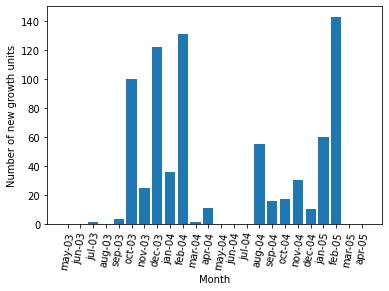

In [119]:
gudistrib = determine_gu_distribution(result)
plot_distribution(gudistrib)

# Fruit production

We compute the distribution of estimated harvest date

In [120]:
harvestdaterange = (weekdate_range(fruiting_cycle_begin(4),fruiting_cycle_end(4)))

def harvest_week_distribution(mtg):
    def toweekid(inflo):
        date = get_fruits_harvest_date(mtg,inflo)
        if date is None: return (2000+get_unit_cycle(mtg,inflo),None)
        d = date.isocalendar()
        return (d[0],d[1]) 

    histo_date = OrderedDict([(d,0) for d in harvestdaterange])

    inflos = get_all_inflo_of_variety_at_cycle(mtg,4)
    for inflo in inflos:
        if get_nb_fruits(mtg,inflo) > 0:
           histo_date[toweekid(inflo)] += get_nb_fruits(mtg,inflo)
    return list(histo_date.values())

def plot_harvest_distribution(values):
    import matplotlib.pyplot as plt
    #strdate = lambda d : str(d[1])# +'-'+str(d[0]-2000)
    dates     = list(map(lambda d : str(d[1])+'/'+str(d[0])[2:], harvestdaterange))
    fig, ax = plt.subplots()
    plt.bar(dates,values)
    ax.set_xticklabels(dates, rotation=80)
    plt.xlabel('Weeks'); plt.ylabel('Number of fruits')

<ipython-input-120-b329ae9fb1d9>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation=80)


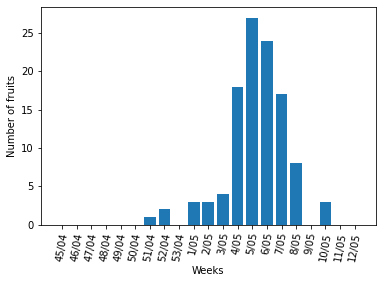

In [121]:
harvest = harvest_week_distribution(result)
plot_harvest_distribution(harvest)

## Current Year Axes Size Distribution

The number of GUs raise from the same initial GU of the initial structure is computed. The distribution of size is then displayed. This allow to compare vigour of the different initial GUs.

In [122]:
import numpy as np

def determine_length_histogram(mtg):
    ucs = [uc for uc in get_all_gus_of_variety(mtg) if get_unit_cycle(mtg, uc) > 3]
    roots = [uc for uc in ucs if get_unit_cycle(mtg,uc) != get_unit_cycle(mtg,mtg.parent(uc))]
    groupid = dict([(uc,uc) for uc in  roots])
    for uc in ucs :       
        if not uc in groupid:
            parents = []
            while not uc in groupid:
                parents.append(uc)
                uc = mtg.parent(uc)
            gid = groupid[uc]
            for p in parents:
                groupid[p] = gid
    histo = np.bincount(np.bincount(list(groupid.values())))[1:]
    return histo

def plot_length_histogram(values):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.bar(range(len(values)),values)
    #ax.set_xticklabels(dates, rotation=80)
    plt.title('Current Year Axes Size Distribution')
    plt.xlabel('Number of GUs in current year axes'); plt.ylabel('Number of current year axes')

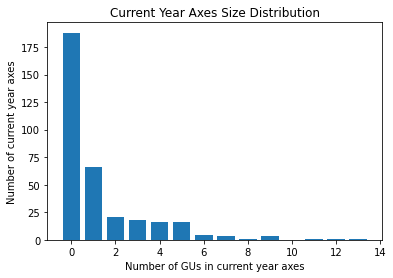

In [123]:
h = determine_length_histogram(result)
plot_length_histogram(h)